In [3]:
import numpy as np
import os
from scipy.spatial import Voronoi, voronoi_plot_2d
import shapely.geometry
import shapely.ops

import geopandas
import pandas as pd

In [4]:
points = np.random.random((10, 2))
vor = Voronoi(points)
voronoi_plot_2d(vor)

<Figure size 640x480 with 1 Axes>

In [5]:
kmeans_df = pd.read_pickle('./assets/clean-data/kmeans-df.pickle')
taxi_df = pd.read_csv('./assets/taxi_zones/taxi_zone_lookup.csv')
taxi_id = geopandas.read_file(os.path.join(".", "assets", "taxi_zones", "taxi_zones_mercator.shp"))

In [11]:
# print(kmeans_df.head())
# for geom in taxi_id["geometry"]:
#     print(geom)
centers = kmeans_df.Centroids[161][0]
# print(len(kmeans_df['ClusterSize']))
# print(kmeans_df.loc[kmeans_df['ClusterSize'] == 7])
# print(taxi_id['geometry'][1])
# kmeans_df_min10 = kmeans_df.loc[kmeans_df['ClusterSize'] >= 10]
# print(taxi_id['geometry'])

# currLocID = 10
# outline = taxi_id['geometry'].loc[taxi_id['LocationID'] == currLocID]
# print(outline)

In [12]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

(4975648.885935388, 4977434.205978039)

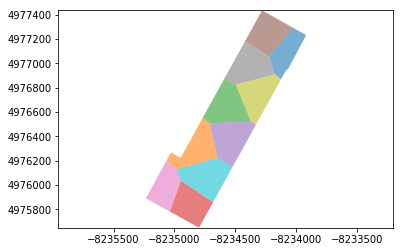

In [106]:
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

vor = Voronoi(centers)
regions, vertices = voronoi_finite_polygons_2d(vor)

# outline = taxi_id['geometry'][161]
# df.loc[df['B'] == 3, 'A'].iloc[0]
outline = taxi_id.loc[taxi_id['LocationID'] == 162, 'geometry'].iloc[0]
# print(outline)

for region in regions:
    polygon = vertices[region]
    # Clipping polygon
    poly = Polygon(polygon)
    poly = poly.intersection(outline)
    polygon = [p for p in poly.exterior.coords]

    plt.fill(*zip(*polygon), alpha=0.6)

# outline.bounds
plt.plot(points[:, 0], points[:, 1], 'ko')
plt.axis('equal')
plt.xlim(outline.bounds[0] - 0.1, outline.bounds[2] + 0.1)
plt.ylim(outline.bounds[1] - 0.1, outline.bounds[3] + 0.1)

In [132]:
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

def getClusterGeoms(row):
    geom_list = []
    if row['ClusterSize'] == 10:
        centers = row['Centroids'][0]
        vor = Voronoi(centers)
        regions, vertices = voronoi_finite_polygons_2d(vor)
        
        currLocID = row['LocationID']
        outline = taxi_id.loc[taxi_id['LocationID'] == currLocID, 'geometry'].iloc[0]
#         outline = taxi_id['geometry'].loc[taxi_id['LocationID'] == currLocID][0]

#         print(type(outline))
        for region in regions:
            polygon = vertices[region]
            # Clipping polygon
            poly = Polygon(polygon)

            if type(outline) == shapely.geometry.multipolygon.MultiPolygon:
                for geom in outline:
                    poly = poly.intersection(geom)
                    polygon = [p for p in poly.exterior.coords]

                    if len(polygon) > 0:
                        shape_poly = Polygon(polygon)
                        geom_list.append(shape_poly)
            else:
                poly = poly.intersection(outline)
                print(type(poly))
                polygon = [p for p in poly.exterior.coords]
                shape_poly = Polygon(polygon)
                geom_list.append(shape_poly)

        print(len(geom_list))

    return geom_list

kmeans_df['ClusterGeometry'] = kmeans_df.apply(getClusterGeoms, axis=1)
print(kmeans_df.head())

<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
10
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
10
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<clas

<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
10
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
10
<class 'shapely.geometry.polygon.Polyg

<class 'shapely.geometry.polygon.Polygon'>
10
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
10
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>


AttributeError: ("'MultiPolygon' object has no attribute 'exterior'", 'occurred at index 32')

In [76]:
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

def getClusterGeometries(row):
    geom_list = []
    if row['ClusterSize'] == 10:
        centers = row['Centroids'][0]
#         print(centers)
        vor = Voronoi(centers)
        regions, vertices = voronoi_finite_polygons_2d(vor)
        
        currLocID = row['LocationID']
        outline = taxi_id['geometry'].loc[taxi_id['LocationID'] == currLocID][0]

        vor = Voronoi(centers)
        regions, vertices = voronoi_finite_polygons_2d(vor)

        print(currLocID)
        print(outline)
        for region in regions:
            polygon = vertices[region]
            # Clipping polygon
            poly = Polygon(polygon)

            if type(outline) == shapely.geometry.multipolygon.MultiPolygon:
                for geom in outline:
                    poly = poly.intersection(geom)
                    polygon = [p for p in poly.exterior.coords]
                    
                    if len(polygon) > 0:
                        geom_list.append(*zip(*polygon))
            else:
                poly = poly.intersection(outline)
                polygon = [p for p in poly.exterior.coords]
                geom_list.append(*zip(*polygon))

    return geom_list

kmeans_df['ClusterGeometry'] = kmeans_df.apply(getClusterGeometries, axis=1)
# outline.bounds
# plt.plot(points[:, 0], points[:, 1], 'ko')
# plt.axis('equal')
# plt.xlim(outline.bounds[0] - 0.1, outline.bounds[2] + 0.1)
# plt.ylim(outline.bounds[1] - 0.1, outline.bounds[3] + 0.1)

1
POLYGON ((-8258175.532737532 4967457.202992616, -8258179.540239202 4967471.738424489, -8258180.542114617 4967484.952472214, -8258167.517734196 4967586.701237594, -8258156.497104603 4967635.593877953, -8258127.44271751 4967762.451597987, -8258115.420212504 4967825.881074967, -8258097.386454997 4967868.167621469, -8258084.362074574 4967946.133920846, -8258076.347071232 4967964.634489884, -8258074.343320403 4967980.49214835, -8258070.335818731 4968001.635732966, -8258044.287057889 4968205.145071901, -8258031.262677461 4968370.334337069, -8258032.264552883 4968542.134132453, -8258029.258926632 4968577.81600689, -8258024.249549546 4968610.854895591, -8258013.228919954 4968655.787963323, -8257996.197037862 4968700.721237497, -8257974.155778689 4968740.368415556, -8257950.110768675 4968772.086273725, -8257925.063883247 4968799.839483999, -8257906.028250318 4968817.020082206, -8257880.98136489 4968836.843886878, -8257854.932604047 4968852.702959543, -8257826.880092368 4968868.562057929, -825

TypeError: ('append() takes exactly one argument (2 given)', 'occurred at index 0')

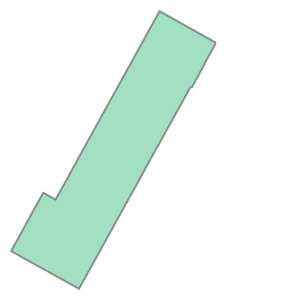

In [8]:
taxi_id = geopandas.read_file(os.path.join(".", "assets", "taxi_zones", "taxi_zones_mercator.shp"))

taxi_id["geometry"][161]